# Arquitetura PerSAM para segmentação de máscaras binárias em imagens de carcaças de animais (ovinos)

Repositório do código original: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/PerSAM/Personalize_SAM_with_one_shot_using_Hugging_Face_(SAM_f).ipynb

## Setup environment

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load model

Here we just load the regular SAM model, as we don't need to do any modifications to it.

In [ ]:
from transformers import AutoProcessor, SamModel

processor = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
model = SamModel.from_pretrained("facebook/sam-vit-huge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

## Load reference image and mask

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ImagesFolder="/content/drive/MyDrive/DEV/carcaca/abate-3"
train_image_path = ImagesFolder+"/C043 (1)/img.png"
train_mask_path = ImagesFolder+"/C043 (1)/label.png"

## Create function to prepare images to model

In [ ]:
import cv2

def prepare_figure(filepath):
  figure = cv2.imread(filepath)
  figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)
  figure = cv2.resize(figure, (256, 256))

  return figure

In [ ]:
ref_image = prepare_figure(train_image_path)

array([[[ 65,  60,  64],
        [ 57,  55,  60],
        [ 62,  61,  65],
        ...,
        [ 90,  86,  85],
        [ 86,  82,  81],
        [ 56,  52,  51]],

       [[ 65,  63,  68],
        [ 64,  62,  67],
        [ 66,  64,  69],
        ...,
        [ 84,  84,  81],
        [ 86,  85,  83],
        [ 42,  38,  37]],

       [[ 65,  63,  68],
        [ 66,  64,  69],
        [ 58,  56,  61],
        ...,
        [ 85,  85,  82],
        [ 77,  76,  74],
        [ 49,  45,  44]],

       ...,

       [[ 98,  97, 100],
        [105, 103, 106],
        [101,  99, 102],
        ...,
        [ 67,  64,  59],
        [ 71,  68,  63],
        [ 71,  68,  61]],

       [[ 99,  94,  98],
        [ 96,  95,  97],
        [ 95,  93,  96],
        ...,
        [ 81,  78,  71],
        [ 83,  80,  73],
        [ 86,  83,  76]],

       [[ 98,  93,  97],
        [ 95,  93,  96],
        [ 80,  78,  79],
        ...,
        [ 89,  84,  77],
        [ 91,  86,  80],
        [ 85,  82,  75]]], dtype=uint8)
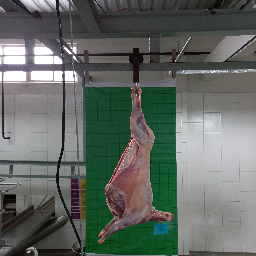

In [ ]:
ref_image

In [ ]:
import numpy as np
import torch

ref_mask = prepare_figure(train_mask_path)
gt_mask = torch.tensor(ref_mask)[:, :, 0] > 0
gt_mask = gt_mask.float().unsqueeze(0).flatten(1)
print(ref_mask.shape)

(256, 256, 3)


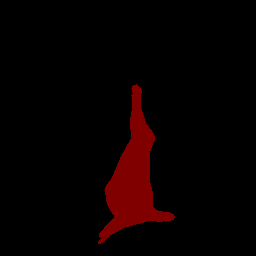

In [ ]:
from PIL import Image

visual_mask = ref_mask.astype(np.uint8)
Image.fromarray(visual_mask)

In [ ]:
gt_mask.unique()

tensor([0., 1.])

## Step 1: get target embedding

The first step is to get an embedding (numerical representation) of the target concept of interest, in this case a dog. For that, we first forward the reference image through SAM's vision encoder to get the image embeddings, and then combine those with the reference mask to come up with a target embedding.

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Step 1: Image features encoding
inputs = processor(images=ref_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

with torch.no_grad():
  image_embeddings = model.get_image_embeddings(pixel_values)
  ref_feat = image_embeddings.squeeze().permute(1, 2, 0)

In [ ]:
import numpy as np
import torch.nn.functional as F
from torchvision.transforms.functional import resize, to_pil_image
import torch
from typing import Tuple

def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def preprocess(x: torch.Tensor, pixel_mean=[123.675, 116.28, 103.53], pixel_std=[58.395, 57.12, 57.375], img_size=1024) -> torch.Tensor:
    """Normalize pixel values and pad to a square input."""

    pixel_mean = torch.Tensor(pixel_mean).view(-1, 1, 1)
    pixel_std = torch.Tensor(pixel_std).view(-1, 1, 1)

    # Normalize colors
    x = (x - pixel_mean) / pixel_std

    # Pad
    h, w = x.shape[-2:]
    padh = img_size - h
    padw = img_size - w
    x = F.pad(x, (0, padw, 0, padh))
    return x

def prepare_mask(image, target_length=1024):
  target_size = get_preprocess_shape(image.shape[0], image.shape[1], target_length)
  mask = np.array(resize(to_pil_image(image), target_size))

  input_mask = torch.as_tensor(mask)
  input_mask = input_mask.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_mask = preprocess(input_mask)

  return input_mask

In [ ]:
# Step 2: interpolate reference mask
ref_mask = prepare_mask(ref_mask)
ref_mask = F.interpolate(ref_mask, size=ref_feat.shape[0: 2], mode="bilinear")
ref_mask = ref_mask.squeeze()[0]

# Step 3: Target feature extraction
target_feat = ref_feat[ref_mask > 0]
target_feat_mean = target_feat.mean(0)
target_feat_max = torch.max(target_feat, dim=0)[0]
target_feat = (target_feat_max / 2 + target_feat_mean / 2).unsqueeze(0)

## Step 2: cosine similarity

Next, we compute cosine similarity between the target embedding and features of the reference image.

In [ ]:
h, w, C = ref_feat.shape
target_feat = target_feat / target_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat / ref_feat.norm(dim=-1, keepdim=True)
ref_feat = ref_feat.permute(2, 0, 1).reshape(C, h * w)
sim = target_feat @ ref_feat

In [ ]:
sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
sim = processor.post_process_masks(sim.unsqueeze(1),
                                   original_sizes=inputs["original_sizes"].tolist(),
                                   reshaped_input_sizes=inputs["reshaped_input_sizes"].tolist(),
                                   binarize=False)
sim = sim[0].squeeze()

## Step 3: obtain location prior

Using this similarity map, we obtain a positive point location, indicating where the target concept (in this case, a dog) is mostly likely to be present in the reference image.

In [ ]:
def point_selection(mask_sim, topk=1):
    # Top-1 point selection
    w, h = mask_sim.shape
    topk_xy = mask_sim.flatten(0).topk(topk)[1]
    topk_x = (topk_xy // h).unsqueeze(0)
    topk_y = (topk_xy - topk_x * h)
    topk_xy = torch.cat((topk_y, topk_x), dim=0).permute(1, 0)
    topk_label = np.array([1] * topk)
    topk_xy = topk_xy.cpu().numpy()

    return topk_xy, topk_label

# Positive location prior
topk_xy, topk_label = point_selection(sim, topk=1)

print("Topk_xy:", topk_xy)
print("Topk_label:", topk_label)

Topk_xy: [[145 138]]
Topk_label: [1]


## Step 4: optimize mask weights

Next, the PerSAM authors introduce 2 learnable weights which will be used to weight the 3 masks that `SamModel` by default generates. We refer to section 3.3 in the [paper](https://arxiv.org/abs/2305.03048) for details. The weights are optimized using both a DICE and sigmoid focal loss.

In [ ]:
def calculate_dice_loss(inputs, targets, num_masks = 1):
    """
    Compute the DICE loss, similar to generalized IOU for masks
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    """
    inputs = inputs.sigmoid()
    inputs = inputs.flatten(1)
    numerator = 2 * (inputs * targets).sum(-1)
    denominator = inputs.sum(-1) + targets.sum(-1)
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss.sum() / num_masks

def calculate_sigmoid_focal_loss(inputs, targets, num_masks = 1, alpha: float = 0.25, gamma: float = 2):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    return loss.mean(1).sum() / num_masks

def postprocess_masks(masks: torch.Tensor, input_size: Tuple[int, ...], original_size: Tuple[int, ...], img_size=1024) -> torch.Tensor:
      """
      Remove padding and upscale masks to the original image size.

      Arguments:
        masks (torch.Tensor): Batched masks from the mask_decoder,
          in BxCxHxW format.
        input_size (tuple(int, int)): The size of the image input to the
          model, in (H, W) format. Used to remove padding.
        original_size (tuple(int, int)): The original size of the image
          before resizing for input to the model, in (H, W) format.

      Returns:
        (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
          is given by original_size.
      """
      masks = F.interpolate(
          masks,
          (img_size, img_size),
          mode="bilinear",
          align_corners=False,
      )
      masks = masks[..., : input_size[0], : input_size[1]]
      masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
      return masks

Optimization is done using the AdamW (Adam with weight decay) optimizer, and a cosine annealing learning rate schedule is used.

In [ ]:
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

class Mask_Weights(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(2, 1, requires_grad=True) / 3)

# Learnable mask weights
mask_weights = Mask_Weights()
mask_weights.to(device)
mask_weights.train()

num_epochs = 1000
log_epoch = 200

optimizer = AdamW(mask_weights.parameters(), lr=1e-3, eps=1e-4)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)

In [ ]:
inputs = processor(ref_image, input_points=[topk_xy.tolist()], input_labels=[topk_label.tolist()], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_points torch.Size([1, 1, 1, 2])
input_labels torch.Size([1, 1, 1])


In [ ]:
gt_mask = gt_mask.to(device)

for train_idx in range(num_epochs):
    # Run the decoder
    with torch.no_grad():
      outputs = model(
          input_points=inputs.input_points,
          input_labels=inputs.input_labels,
          image_embeddings=image_embeddings.to(device),
          multimask_output=True,
      )

    logits_high = postprocess_masks(masks=outputs.pred_masks.squeeze(1),
                                    input_size=inputs.reshaped_input_sizes[0].tolist(),
                                    original_size=inputs.original_sizes[0].tolist())
    logits_high = logits_high[0].flatten(1)

    # Weighted sum three-scale masks
    weights = torch.cat((1 - mask_weights.weights.sum(0).unsqueeze(0), mask_weights.weights), dim=0)
    logits_high = logits_high * weights
    logits_high = logits_high.sum(0).unsqueeze(0)

    dice_loss = calculate_dice_loss(logits_high, gt_mask)
    focal_loss = calculate_sigmoid_focal_loss(logits_high, gt_mask)
    loss = dice_loss + focal_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if train_idx % log_epoch == 0:
        print('Train Epoch: {:} / {:}'.format(train_idx, num_epochs))
        current_lr = scheduler.get_last_lr()[0]
        print('LR: {:.6f}, Dice_Loss: {:.4f}, Focal_Loss: {:.4f}'.format(current_lr, dice_loss.item(), focal_loss.item()))

Train Epoch: 0 / 1000
LR: 0.001000, Dice_Loss: 0.0181, Focal_Loss: 0.0007
Train Epoch: 200 / 1000
LR: 0.000904, Dice_Loss: 0.0138, Focal_Loss: 0.0008
Train Epoch: 400 / 1000
LR: 0.000653, Dice_Loss: 0.0125, Focal_Loss: 0.0009
Train Epoch: 600 / 1000
LR: 0.000344, Dice_Loss: 0.0120, Focal_Loss: 0.0010
Train Epoch: 800 / 1000
LR: 0.000095, Dice_Loss: 0.0119, Focal_Loss: 0.0010


In [ ]:
mask_weights.eval()
weights = torch.cat((1 - mask_weights.weights.sum(0).unsqueeze(0), mask_weights.weights), dim=0)
weights_np = weights.detach().cpu().numpy()
print('======> Mask weights:\n', weights_np)

======> Mask weights:
 [[0.6000896 ]
 [0.3869198 ]
 [0.01299059]]


## Load test images

Next, let's load the test images on which we'd like to perform a new segmentation.

In [ ]:
imgs_list = []
masks_list = []

for dirpath, dirnames, filenames in os.walk(ImagesFolder):
  for filename in filenames:
    if filename == "img.png":
      imgs_list.append(os.path.join(dirpath, filename))
  for filename in filenames:
    if filename == "label.png":
      masks_list.append(os.path.join(dirpath, filename))

In [ ]:
masks_list.pop()

'/content/drive/MyDrive/DEV/carcaca/abate-3/C037 (2)/label.png'

In [ ]:
print(imgs_list)

['/content/drive/MyDrive/DEV/carcaca/abate-3/C032 (1)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C031 (3)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C031 (1)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C030 (1)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C030 (3)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C032 (3)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C031 (2)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C032 (2)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C030 (2)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C029 (3)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C036 (2)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C033 (3)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C001 (2)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C034 (2)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C034 (1)/img.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C001 (1)/i

In [ ]:
print(masks_list)

['/content/drive/MyDrive/DEV/carcaca/abate-3/C032 (1)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C031 (3)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C031 (1)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C030 (1)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C030 (3)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C032 (3)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C031 (2)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C032 (2)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C030 (2)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C029 (3)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C036 (2)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C033 (3)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C001 (2)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C034 (2)/label.png', '/content/drive/MyDrive/DEV/carcaca/abate-3/C034 (1)/label.png', '/content/drive/MyDrive/

In [ ]:
print(f"There are {len(imgs_list)} images and {len(masks_list)} to test.")

There are 119 images and 119 to test.


## Function to make the segmentation

In [ ]:
def make_segmentation(test_image):
  # 1.
  # prepare for the model
  inputs = processor(images=test_image, return_tensors="pt").to(device)

  # Image feature encoding
  with torch.no_grad():
    test_image_embeddings = model.get_image_embeddings(inputs.pixel_values).squeeze()

  # 2.
  # Cosine similarity
  C, h, w = test_image_embeddings.shape
  test_feat = test_image_embeddings / test_image_embeddings.norm(dim=0, keepdim=True)
  test_feat = test_feat.reshape(C, h * w)
  sim = target_feat @ test_feat

  sim = sim.reshape(1, 1, h, w)
  sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
  sim = processor.post_process_masks(sim.unsqueeze(1), original_sizes=inputs["original_sizes"].tolist(), reshaped_input_sizes=inputs["reshaped_input_sizes"].tolist(),
                                   binarize=False)
  sim = sim[0].squeeze()

  # 3.
  # Positive location prior
  topk_xy, topk_label = point_selection(sim, topk=1)

  #print("Topk_xy:", topk_xy)
  #print("Topk_label:", topk_label)

  inputs = processor(test_image, input_points=[topk_xy.tolist()], input_labels=[topk_label.tolist()], return_tensors="pt").to(device)

  # 4.
  with torch.no_grad():
    outputs = model(
        input_points=inputs.input_points,
        input_labels=inputs.input_labels,
        image_embeddings=test_image_embeddings.unsqueeze(0),
        multimask_output=True,
    )
  logits = outputs.pred_masks[0].squeeze(0).detach().cpu().numpy()
  logits = logits * weights_np[..., None]
  logit = logits.sum(0)

  # Weighted sum three-scale masks
  logits_high = logits_high = postprocess_masks(masks=outputs.pred_masks.squeeze(1),
                                      input_size=inputs.reshaped_input_sizes[0].tolist(),
                                      original_size=inputs.original_sizes[0].tolist())
  logits_high = logits_high[0] * weights.unsqueeze(-1)
  logit_high = logits_high.sum(0)
  mask = (logit_high > 0).detach().cpu().numpy()
  y, x = np.nonzero(mask)
  x_min = x.min()
  x_max = x.max()
  y_min = y.min()
  y_max = y.max()
  input_box = [[x_min, y_min, x_max, y_max]]

  #print(input_box)

  # 5.
  input_boxes = processor(test_image, input_boxes=[input_box], return_tensors="pt").input_boxes.to(device)

  # Cascaded Post-refinement-1
  with torch.no_grad():
    outputs_1 = model(
                input_points=inputs.input_points,
                input_labels=inputs.input_labels,
                input_boxes=input_boxes,
                input_masks=torch.tensor(logit[None, None, :, :], device=device),
                image_embeddings=test_image_embeddings.unsqueeze(0),
                multimask_output=True)
  # Cascaded Post-refinement-2
  masks = processor.image_processor.post_process_masks(outputs_1.pred_masks.cpu(),
                                                      inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0].squeeze().numpy()

  best_idx = torch.argmax(outputs_1.iou_scores).item()
  y, x = np.nonzero(masks[best_idx])
  x_min = x.min()
  x_max = x.max()
  y_min = y.min()
  y_max = y.max()
  input_box = [[[x_min, y_min, x_max, y_max]]]

  #print("Input boxes:", input_boxes)

  input_boxes = processor(test_image, input_boxes=[input_box], return_tensors="pt").input_boxes.to(device)

  final_outputs = model(
      input_points=inputs.input_points,
      input_labels=inputs.input_labels,
      input_boxes=input_boxes,
      input_masks=outputs_1.pred_masks.squeeze(1)[:,best_idx: best_idx + 1, :, :],
      image_embeddings=test_image_embeddings.unsqueeze(0),
      multimask_output=True)

  best_idx = torch.argmax(final_outputs.iou_scores).item()
  masks = processor.image_processor.post_process_masks(final_outputs.pred_masks.cpu(),
                                                     inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0].squeeze().numpy()

  return best_idx, masks

## Generate masks

In [ ]:
final_masks = []

for idx, img_path in enumerate(imgs_list):
  test_image = prepare_figure(img_path)
  segmentation_results = make_segmentation(test_image)

  best_idx = segmentation_results[0]
  masks = segmentation_results[1]
  mask = masks[best_idx]
  final_masks.append(mask)

## Visualize and save some predictions
We can finally visualize the final masks and save them into a drive folder


In [ ]:
import matplotlib.pyplot as plt

def show_mask(mask, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255, 0, 0, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    return mask_image

In [ ]:
# Function to save the segmented masks into drive
from PIL import Image
import albumentations as A

def save_segmask(img_path, seg_mask, dirname, filename):

  # Resize the segmented mask to the original shape of image
  image = cv2.imread(img_path)
  h, w = image.shape[0], image.shape[1]
  np_mask = np.array(seg_mask, dtype=np.uint8) * 255
  resize = A.Resize(height=h, width=w)
  resized_mask = resize(image=np_mask)['image']

  # Save into drive folder
  cv2.imwrite(filename, resized_mask)

In [ ]:
# Function to plot image x true_mask x pred_mask
def plot(img, true_mask, pred_mask):
  fig, ax = plt.subplots(1, 3, figsize=(8, 8))

  ax[0].imshow(img)
  ax[0].set_title("Image")
  ax[1].imshow(true_mask)
  ax[1].set_title("Original mask")

  ax[2].imshow(pred_mask, cmap="gray")
  #ax[2].imshow(np.array(img))
  #ax[2].imshow(show_mask(pred_mask))
  ax[2].set_title("Predicted mask")

  fig.tight_layout()
  fig.show()

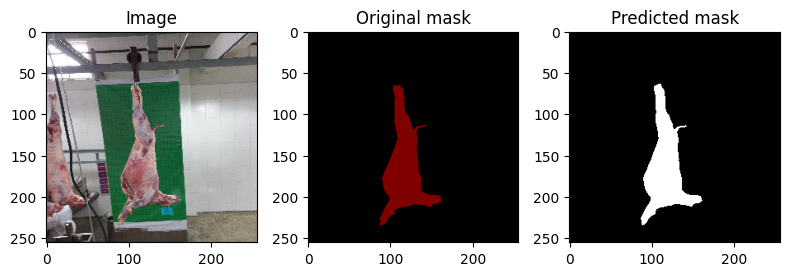

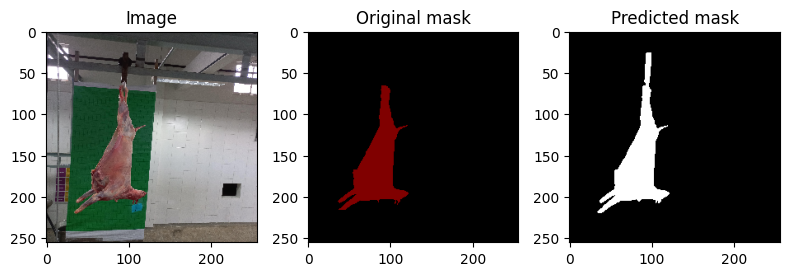

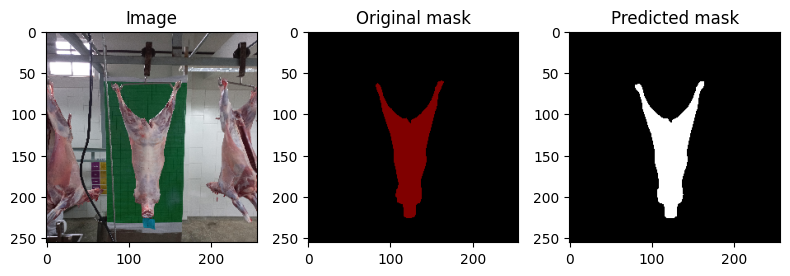

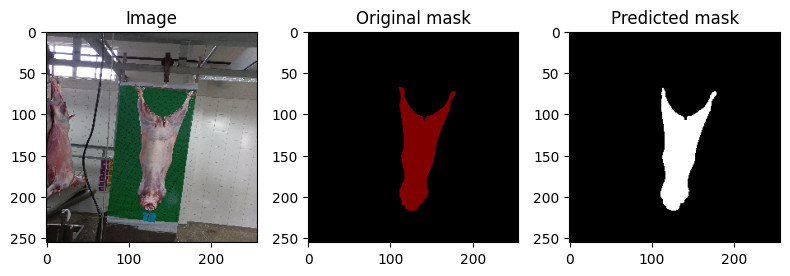

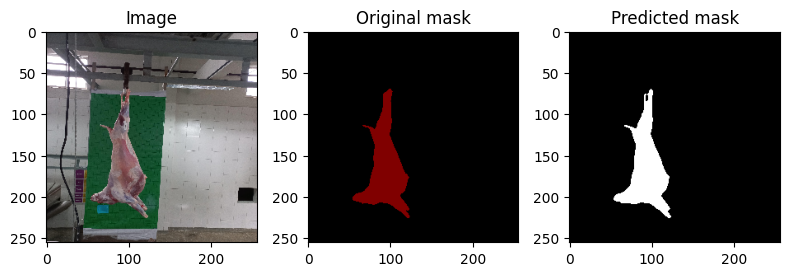

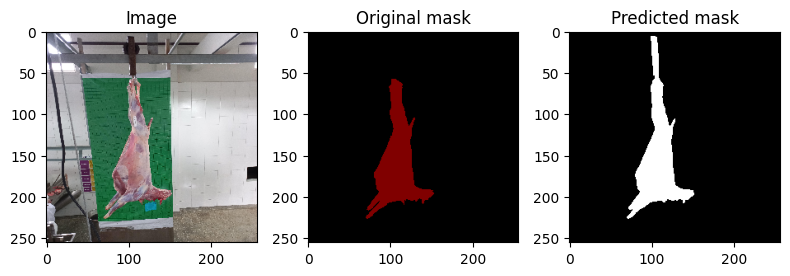

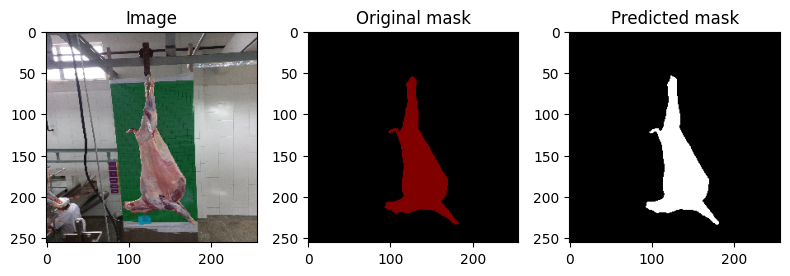

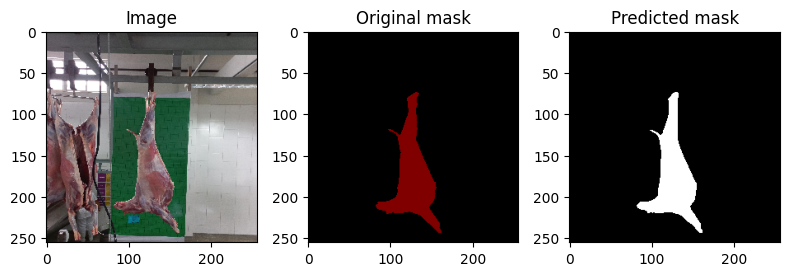

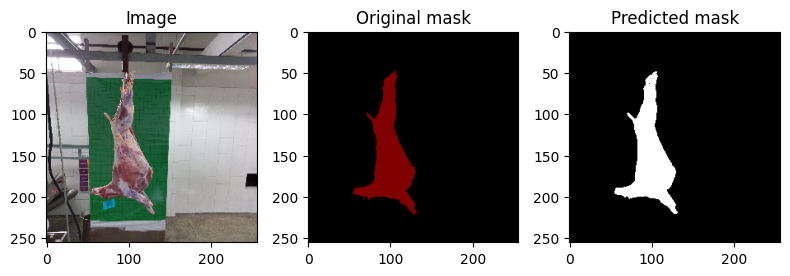

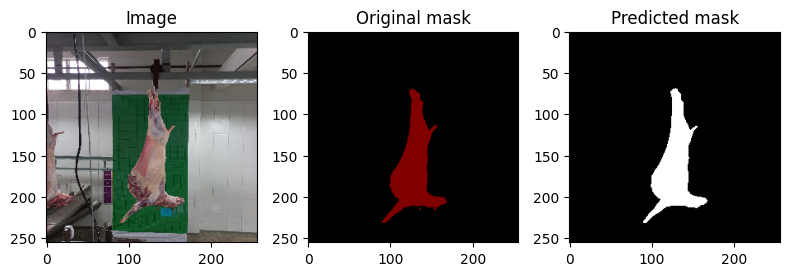

In [ ]:
for idx in range(len(imgs_list)):
  if idx % 12 == 0:
    # Segmenting
    img = prepare_figure(imgs_list[idx])
    true_mask = prepare_figure(masks_list[idx])
    pred_mask = final_masks[idx]

    # Saving
    dirname = '/content/drive/MyDrive/DEV/carcaca/mask-segmentation-persam'
    filename = f"{dirname}/persam-mask-{idx}.png"
    save_segmask(imgs_list[idx], pred_mask, dirname, filename)

    # Plotting
    plot(img, true_mask, pred_mask)

## Evaluate model (IoU metric)

In [ ]:
from sklearn.metrics import jaccard_score

true_masks, seg_masks, ious = [], [], []

for idx in range(len(imgs_list)):
  # Preparing true_mask
  true_mask = prepare_figure(masks_list[idx])
  true_mask = torch.tensor(true_mask)[:, :, 0] > 0
  true_mask = true_mask.flatten()
  true_masks.append(true_mask.numpy().astype(int))

  # Preparing seg_mask
  seg_mask = final_masks[idx].astype(int)
  seg_mask = seg_mask.flatten()
  seg_masks.append(seg_mask)

  # Calculating IoU for each image
  iou = jaccard_score(true_mask, seg_mask, average='binary')
  ious.append(iou)

In [ ]:
true_masks = np.array(true_masks).flatten()
seg_masks = np.array(seg_masks).flatten()

In [ ]:
true_masks.shape, seg_masks.shape

((7798784,), (7798784,))

In [ ]:
# Average IoU for all segmented masks
average_iou = jaccard_score(true_masks, seg_masks, average='binary')
average_iou

0.9585483331841653

In [ ]:
import pandas as pd

# Save the metrics
results =  {"img_path": imgs_list,
            "mask_path": masks_list,
            "IoU": ious}

results_df = pd.DataFrame(results)

## Results for each segmented image

In [ ]:
results_df

,img_path,mask_path,IoU
0,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,0.978188
1,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,0.978738
2,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,0.979873
3,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,0.910295
4,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,/content/drive/MyDrive/DEV/carcaca/abate-3/C03...,0.984835
...,...,...,...
114,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,0.982133
115,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,0.977282
116,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,0.978945
117,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,/content/drive/MyDrive/DEV/carcaca/abate-3/C04...,0.975072


In [ ]:
# Saving results (.csv)
with open(f"{dirname}/PerSAM-results.csv", "w") as f:
  f.write(results_df.to_csv())

In [ ]:
fig = prepare_figure('/content/drive/MyDrive/DEV/carcaca/abate-3/C038 (2)/label.png')

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
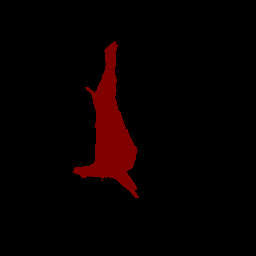

In [ ]:
fig

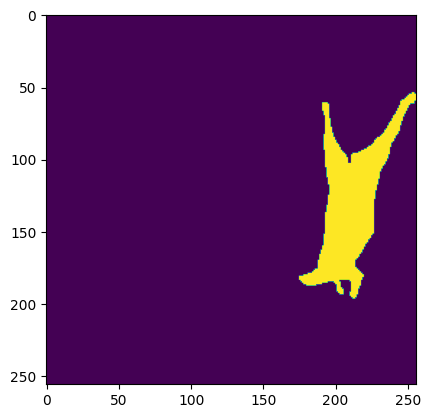

In [ ]:
plt.imshow(final_masks[107])